In [62]:
import os
import sys
sys.path.append("/home/rohit/PhD_Work/GM_my_version/Graph_matching/")
from sklearn.cluster import KMeans
import networkx as nx
import numpy as np
from graph_generation.load_graphs_and_create_metadata import dataset_metadata
from graph_matching_tools.metrics import matching
import matplotlib.pyplot as plt
import scipy.io as sio
import pickle
import matplotlib.ticker as plticker

In [ ]:
path_to_graph_folder = '/home/rohit/PhD_Work/GM_my_version/Graph_matching/data/simu_graph/NEW_SIMUS_JULY_11/'
path_to_dummy_graph_folder = '/home/rohit/PhD_Work/GM_my_version/Graph_matching/data/simu_graph/NEW_SIMUS_JULY_11_with_dummy/'

In [ ]:
def get_permutation_matrix_from_dictionary(matching, g_sizes):
    """
    Create the full permutation matrix from the matching result
    :param matching: the matching result for each graph (nodes number, assignment)
    :param g_sizes: the list of the size of the different graph
    :return: the full permutation matrix
    """
    f_size = int(np.sum(g_sizes))
    res = np.zeros((f_size, f_size))

    idx1 = 0
    for i_g1 in range(len(g_sizes)):
        idx2 = 0
        for i_g2 in range(len(g_sizes)):
            match = matching["{},{}".format(i_g1, i_g2)]
            for k in match:
                res[idx1 + int(k), idx2 + match[k]] = 1
            idx2 += g_sizes[i_g2]
        idx1 += g_sizes[i_g1]
        
    np.fill_diagonal(res,1)
    return res

In [ ]:
def remove_dummy_rowcol_X(bulk_X, graphs):
    
    dummy_mask = [list(nx.get_node_attributes(graph,'is_dummy').values()) for graph in graphs]
    dummy_mask = sum(dummy_mask,[])
    dummy_indexes = [i for i in range(len(dummy_mask)) if dummy_mask[i]==True]     
    
    bulk_X = np.delete(bulk_X,dummy_indexes,0) # delete the dummy rows
    bulk_X = np.delete(bulk_X,dummy_indexes,1) # delete the dummy columns
    
    return bulk_X

In [ ]:
trials = np.sort(os.listdir(path_to_graph_folder))

In [ ]:
scores = {100:[],200:[],400:[],1000:[]}
prec_scores = {100:[],200:[],400:[],1000:[]}
rec_scores = {100:[],200:[],400:[],1000:[]}


for trial in trials:
    print('trial: ', trial)
    
    all_files = os.listdir(path_to_graph_folder+trial)
    
    for folder in all_files:
        
        
        if os.path.isdir(path_to_graph_folder+trial+'/'+ folder):
            
            print('Noise folder: ',folder)
            
            path_to_graphs = path_to_graph_folder + '/' + trial + '/' + folder+'/graphs/'
            path_to_dummy_graphs = path_to_dummy_graph_folder + '/' + trial +'/' + folder + '/0/graphs/'
            path_to_groundtruth_ref = path_to_graph_folder + '/' + trial +'/' + folder + '/permutation_to_ref_graph.gpickle'
            path_to_groundtruth  = path_to_graph_folder + '/' + trial + '/' + folder + '/ground_truth.gpickle'
            
            noise = folder.split(',')[0].split('_')[1]
            
            if trial == '4' or trial == '6':
                if noise == '400':
                    continue

            graph_meta = dataset_metadata(path_to_graphs, path_to_groundtruth_ref)
            ground_truth =  nx.read_gpickle(path_to_groundtruth)   
            res = get_permutation_matrix_from_dictionary(ground_truth, graph_meta.sizes)
            
            
            all_dummy_graphs = [nx.read_gpickle(path_to_dummy_graphs+'/'+g) for g in np.sort(os.listdir(path_to_dummy_graphs))]
            X_msync = sio.loadmat(path_to_graph_folder + '/' + trial + '/' + folder +'/X_cao_cst_o.mat')['X']            
            dummy_mask = [list(nx.get_node_attributes(graph,'is_dummy').values()) for graph in all_dummy_graphs]
            dummy_mask = sum(dummy_mask,[])
            dummy_indexes = [i for i in range(len(dummy_mask)) if dummy_mask[i]==True]            
            X_msync = np.delete(X_msync,dummy_indexes,0) # delete the dummy rows
            X_msync = np.delete(X_msync,dummy_indexes,1) # delete the dummy columns
            
            
            print('res shape: ',res.shape)
            print('X shape: ',X_msync.shape)
               
            
            f1, prec, rec = matching.compute_f1score(X_msync,res)
            
            scores[int(noise)].append(f1)
            prec_scores[int(noise)].append(prec)
            rec_scores[int(noise)].append(rec)

In [ ]:
nx.write_gpickle(scores,'NEW_SIMU_CAO_score'+'.gpickle')
nx.write_gpickle(prec_scores,'NEW_SIMU_CAO_score_prec_scores'+'.gpickle')
nx.write_gpickle(rec_scores,'NEW_SIMU_CAO_score_rec_scores'+'.gpickle')

In [ ]:
# # CAO for two trials

# scores_selected = {100: [0.07575848754205779,
#   0.07814004910410795],
#  400: [0.3610063028572132, 0.3843341603488669],
#  1000: [0.6272369172851308,
#   0.6457353013735544],
#  1300: [0.7557834176288084,
#   0.7515356692225564]}

# # CAO for two trials prec scores

# CAO_prec = {100: [0.06940255491618295,
#   0.08012665815255075],
#  400: [0.33249761899362795, 0.35625069398376574],
#  1000: [0.6172584181139315,
#   0.5847887618063963],
#  1300: [0.7009452776744259,
#   0.6994513562888791,
#   0.7219446167567614]}

# CAO_rec = {100: [0.08223609723609723,
#   0.09426311196571033],
#  400: [0.394862188291054, 0.41722420711995695],
#  1000: [0.7230928714145982,
#   0.6913494371020555],
#  1300: [0.8199302973202821,
#   0.8120009329062546]}

In [40]:
def score_mean_std(scores):
    
    avg_scores = []
    std_scores = []

    for keys,values in scores.items():
        avg_scores.append(np.mean(values))
        std_scores.append(np.std(values))
        
    return np.array(avg_scores), np.array(std_scores)

In [3]:
# # F1 Scores

#k_70 = nx.read_gpickle('NEW_SIMU_kmeans_F1_score_k_70.gpickle')
#k_90 = nx.read_gpickle('NEW_SIMU_kmeans_F1_score_k_90.gpickle')
#k_110 = nx.read_gpickle('NEW_SIMU_kmeans_F1_score_k_110.gpickle')
kergm_scores = nx.read_gpickle('NEW_SIMU_KerGM_score.gpickle')
m_Sync_scores = nx.read_gpickle('NEW_SIMU_mSync_score.gpickle')
mALS_scores = nx.read_gpickle('NEW_SIMU_mALS_score.gpickle')
CAO_scores = nx.read_gpickle('NEW_SIMU_CAO_score.gpickle')
Match_eig_scores = pickle.load(open( "scores_match_eig.pickle", "rb" ))

In [4]:
# # Precision Scores

#k_70_scores_prec = nx.read_gpickle('NEW_SIMU_kmeans_prec_score_k_70.gpickle')
#k_90_scores_prec = nx.read_gpickle('NEW_SIMU_kmeans_prec_score_k_90.gpickle')
#k_110_scores_prec = nx.read_gpickle('NEW_SIMU_kmeans_prec_score_k_110.gpickle')
kergm_scores_prec = nx.read_gpickle('NEW_SIMU_KerGM_score_prec_scores.gpickle')
m_Sync_scores_prec = nx.read_gpickle('NEW_SIMU_mSync_score_prec_scores.gpickle')
#m_Sync_kmeans_scores_prec = nx.read_gpickle('mSync_kmeans_rec_scores.gpickle')
mALS_score_prec = nx.read_gpickle('NEW_SIMU_mALS_score_prec_scores.gpickle')
CAO_score_prec = nx.read_gpickle('NEW_SIMU_CAO_score_prec_scores.gpickle')
Match_eig_scores_prec = pickle.load(open( "precision_match_eig.pickle", "rb" ))

#HiPPi_score_prec = nx.read_gpickle('Hippi_kmeans_rec_scores.gpickle')

In [5]:
# # Recall Scores

#k_70_scores_rec = nx.read_gpickle('NEW_SIMU_kmeans_rec_score_k_70.gpickle')
#k_90_scores_rec = nx.read_gpickle('NEW_SIMU_kmeans_rec_score_k_90.gpickle')
#k_110_scores_rec = nx.read_gpickle('NEW_SIMU_kmeans_rec_score_k_110.gpickle')
kergm_scores_rec = nx.read_gpickle('NEW_SIMU_KerGM_score_rec_scores.gpickle')
m_Sync_scores_rec = nx.read_gpickle('NEW_SIMU_mSync_score_rec_scores.gpickle')
#m_Sync_kmeans_scores_prec = nx.read_gpickle('mSync_kmeans_rec_scores.gpickle')
mALS_score_rec = nx.read_gpickle('NEW_SIMU_mALS_score_rec_scores.gpickle')
CAO_score_rec = nx.read_gpickle('NEW_SIMU_CAO_score_rec_scores.gpickle')
Match_eig_scores_rec = pickle.load(open( "recall_match_eig.pickle", "rb" ))

#HiPPi_score_prec = nx.read_gpickle('Hippi_kmeans_rec_scores.gpickle')

In [80]:
# k_70_mean, k_70_std  = score_mean_std(k_70)
# k_90_mean, k_90_std  = score_mean_std(k_90)
# k_110_mean, k_110_std = score_mean_std(k_110)
kergm_mean, kergm_std = score_mean_std(kergm_scores)
msync_mean, msync_std = score_mean_std(m_Sync_scores)
mALS_mean, mALS_std = score_mean_std(mALS_scores)
CAO_mean, CAO_std = score_mean_std(CAO_scores)
msync_kmeans_mean, msync_kmeans_std = score_mean_std(m_Sync_scores)
Match_eig_mean, Match_eig_std = score_mean_std(Match_eig_scores)

In [81]:
#k_70_prec, k_70_prec_std  = score_mean_std(k_70_scores_prec)
#k_90_prec, k_90_prec_std  = score_mean_std(k_90_scores_prec)
#k_110_prec, k_110_prec_std = score_mean_std(k_110_scores_prec)
kergm_prec, kergm_prec_std = score_mean_std(kergm_scores_prec)
msync_prec, msync_prec_std = score_mean_std(m_Sync_scores_prec)
mALS_prec, mALS_prec_std = score_mean_std(mALS_score_prec)
#msync_kmeans_prec, msync_kmeans_std = score_mean_std(m_Sync_kmeans_scores_prec)
#Hippi_prec, Hippi_std = score_mean_std(HiPPi_score_prec)
CAO_prec, CAO_prec_std = score_mean_std(CAO_score_prec)
Match_eig_prec, Match_eig_prec_std = score_mean_std(Match_eig_scores_prec)

In [82]:
#k_70_rec, k_70_rec_std  = score_mean_std(k_70_scores_rec)
#k_90_rec, k_90_rec_std  = score_mean_std(k_90_scores_rec)
#k_110_rec, k_110_rec_std = score_mean_std(k_110_scores_rec)
kergm_rec, kergm_rec_std = score_mean_std(kergm_scores_rec)
msync_rec, msync_rec_std = score_mean_std(m_Sync_scores_rec)
mALS_rec, mALS_rec_std = score_mean_std(mALS_score_rec)
#msync_kmeans_prec, msync_kmeans_std = score_mean_std(m_Sync_kmeans_scores_prec)
#Hippi_prec, Hippi_std = score_mean_std(HiPPi_score_prec)
CAO_rec, CAO_rec_std = score_mean_std(CAO_score_rec)
Match_eig_rec, Match_eig_rec_std = score_mean_std(Match_eig_scores_rec)

# F1 Score

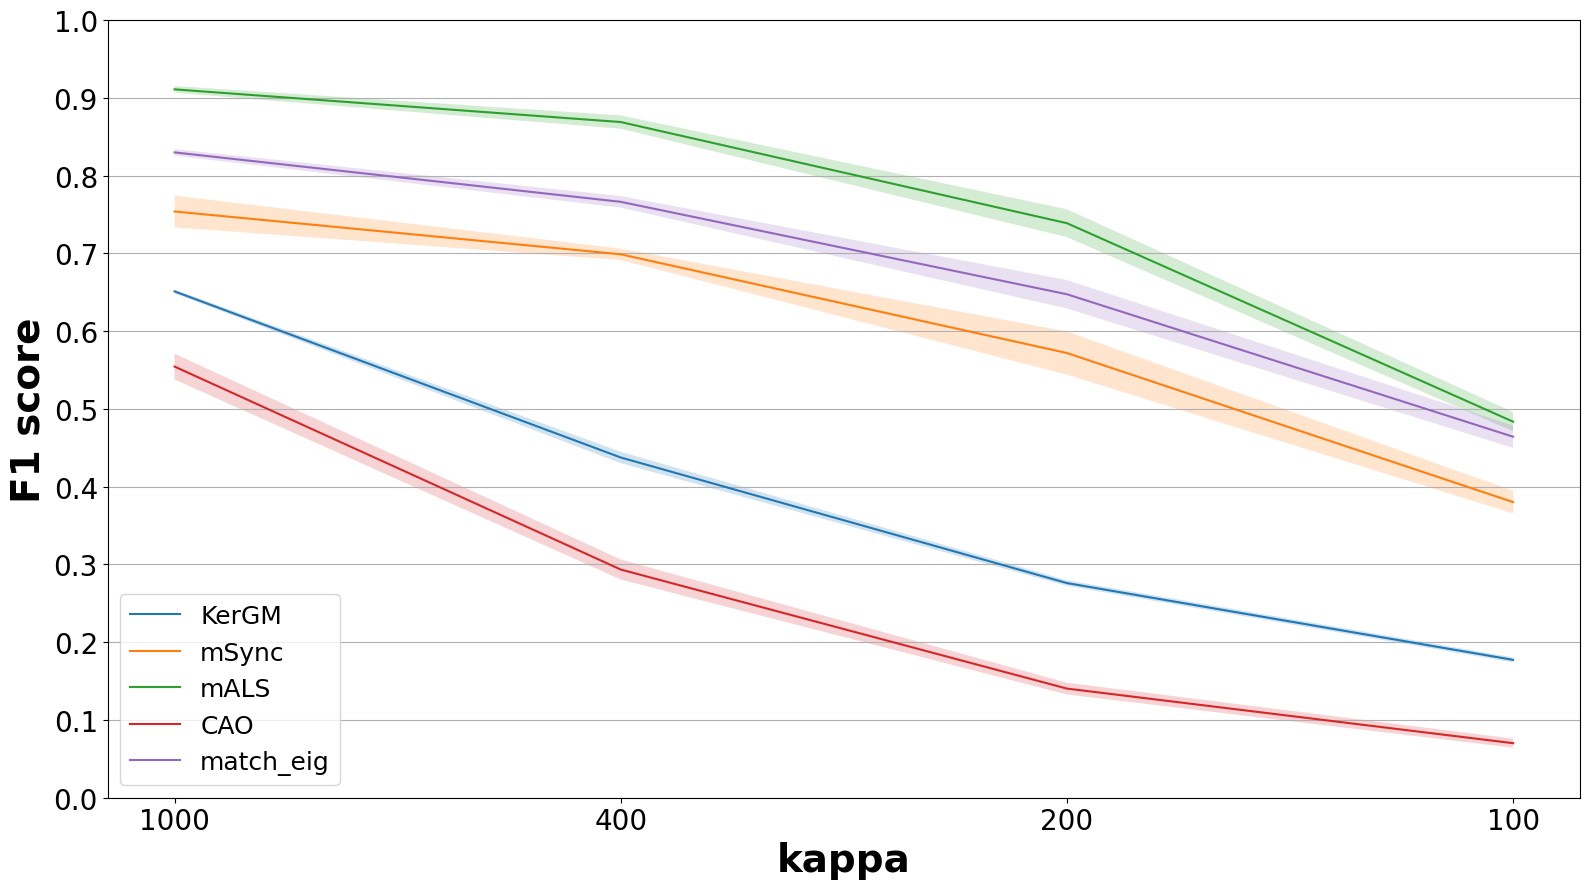

In [83]:
fig = plt.figure(figsize=(16, 9))

# plt.plot(list(k_70.keys()), k_70_mean ,label = 'kmeans k = 70')
# plt.fill_between(list(k_70.keys()), k_70_mean - k_70_std, k_70_mean + k_70_std, alpha=0.2)

# plt.plot(list(k_90.keys()), k_90_mean ,label = 'kmeans k = 90')
# plt.fill_between(list(k_90.keys()), k_90_mean - k_90_std, k_90_mean + k_90_std, alpha=0.2)

# plt.plot(list(k_110.keys()), k_110_mean ,label = 'kmeans k = 110')
# plt.fill_between(list(k_110.keys()), k_110_mean - k_110_std, k_110_mean + k_110_std, alpha=0.2)

strkergm = [str(k) for k in list(kergm_scores.keys())]

plt.plot(strkergm, kergm_mean ,label = 'KerGM')
plt.fill_between(strkergm, kergm_mean - kergm_std, kergm_mean + kergm_std, alpha=0.2)

plt.plot(strkergm, msync_mean ,label = 'mSync')
plt.fill_between(strkergm, msync_mean - msync_std, msync_mean + msync_std, alpha=0.2)

plt.plot(strkergm, mALS_mean ,label = 'mALS')
plt.fill_between(strkergm, mALS_mean - mALS_std, mALS_mean + mALS_std, alpha=0.2)

# plt.plot(list(mALS_scores.keys()), msync_kmeans_mean ,label = 'mSync kmeans')
# plt.fill_between(list(m_Sync_scores.keys()), msync_kmeans_mean - msync_kmeans_std, msync_kmeans_mean + msync_kmeans_std, alpha=0.2)

plt.plot(strkergm, CAO_mean ,label = 'CAO')
plt.fill_between(strkergm, CAO_mean - CAO_std, CAO_mean + CAO_std, alpha=0.2)

plt.plot(strkergm, Match_eig_mean ,label = 'match_eig')
plt.fill_between(strkergm, Match_eig_mean - Match_eig_std, Match_eig_mean + Match_eig_std, alpha=0.2)

plt.xlabel('kappa',fontweight="bold",fontsize=28)
plt.ylabel('F1 score',fontweight="bold",fontsize=28)
plt.legend(loc = 'lower left')
#plt.title('F1 Score curve',fontweight="bold",fontsize=24)
plt.gca().yaxis.grid(True)
plt.gca().invert_xaxis()
plt.legend(loc=3, prop={'size': 18})

ytck = list(np.arange(0,1.1,0.1))

plt.xticks(fontsize=20)
plt.yticks(ytck,fontsize=20)

plt.show()
fig.savefig('NEW SIMU Scores matcheig.png')

# Precision

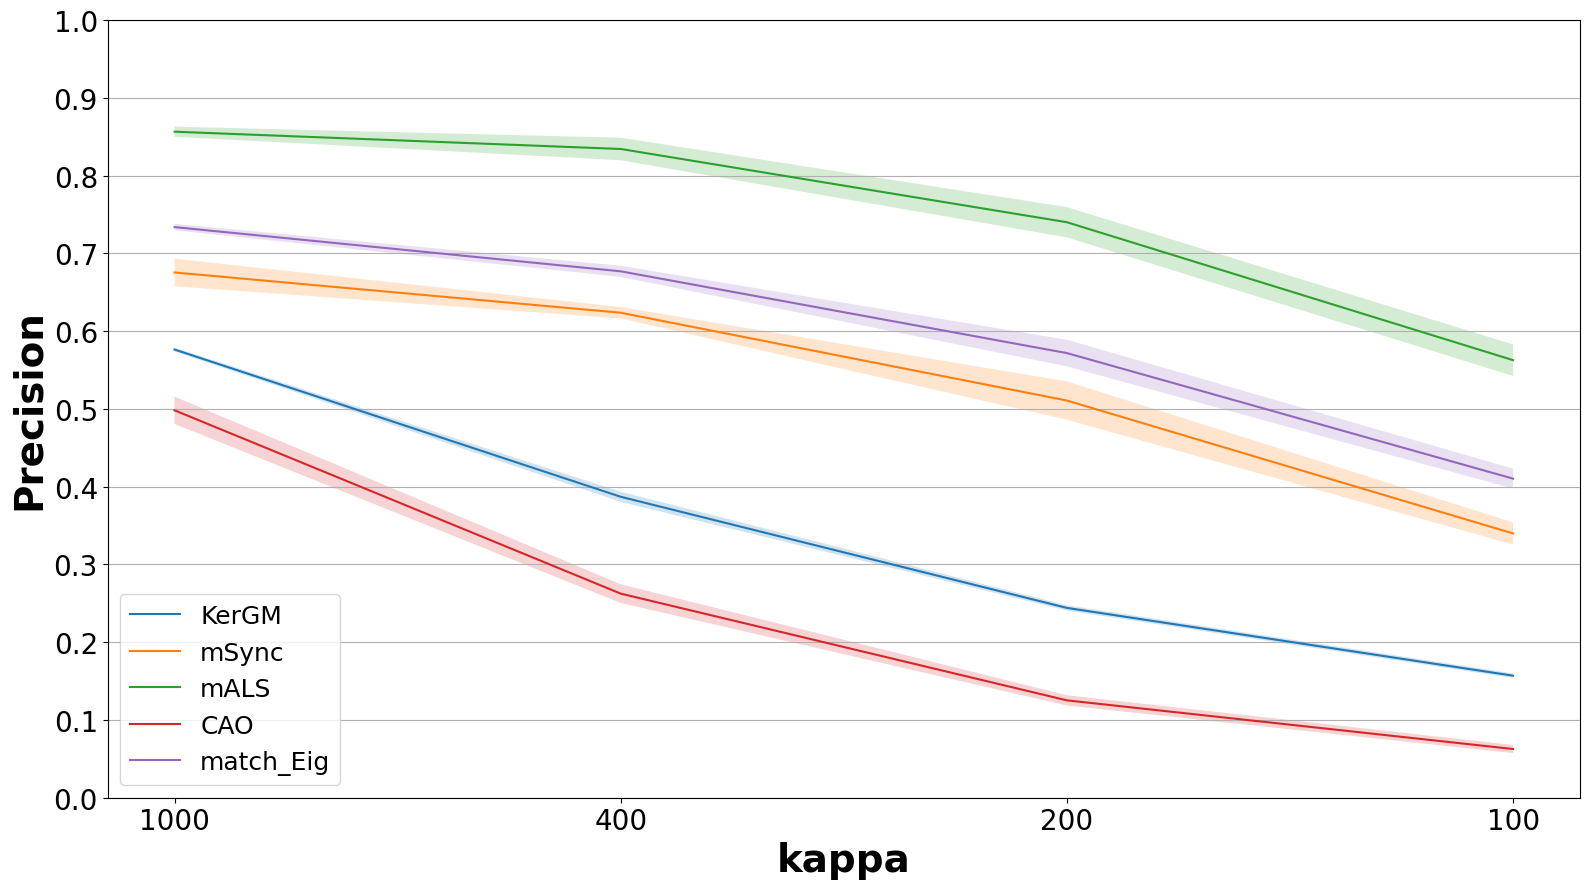

In [90]:
strkergm = [str(k) for k in list(kergm_scores.keys())]

fig = plt.figure(figsize=(16, 9))

# plt.plot(list(k_70.keys()), k_70_prec ,label = 'kmeans k = 70')
# plt.fill_between(list(k_70.keys()), k_70_prec - k_70_prec_std, k_70_prec + k_70_prec_std, alpha=0.2)

# plt.plot(list(k_90.keys()), k_90_prec ,label = 'kmeans k = 90')
# plt.fill_between(list(k_90.keys()), k_90_prec - k_90_prec_std, k_90_prec + k_90_prec_std, alpha=0.2)

# plt.plot(list(k_110.keys()), k_110_prec ,label = 'kmeans k = 110')
# plt.fill_between(list(k_110.keys()), k_110_prec - k_110_prec_std, k_110_prec + k_110_prec_std, alpha=0.2)

plt.plot(strkergm, kergm_prec ,label = 'KerGM')
plt.fill_between(strkergm, kergm_prec - kergm_prec_std, kergm_prec + kergm_prec_std, alpha=0.2)

plt.plot(strkergm, msync_prec ,label = 'mSync')
plt.fill_between(strkergm, msync_prec - msync_prec_std, msync_prec + msync_prec_std, alpha=0.2)

plt.plot(strkergm, mALS_prec ,label = 'mALS')
plt.fill_between(strkergm, mALS_prec - mALS_prec_std, mALS_prec + mALS_prec_std, alpha=0.2)

# plt.plot(list(mALS_scores.keys()), msync_kmeans_mean ,label = 'mSync kmeans')
# plt.fill_between(list(m_Sync_scores.keys()), msync_kmeans_mean - msync_kmeans_std, msync_kmeans_mean + msync_kmeans_std, alpha=0.2)

plt.plot(strkergm, CAO_prec ,label = 'CAO')
plt.fill_between(strkergm, CAO_prec - CAO_prec_std, CAO_prec + CAO_prec_std, alpha=0.2)

plt.plot(strkergm, Match_eig_prec ,label = 'match_Eig')
plt.fill_between(strkergm, Match_eig_prec - Match_eig_prec_std, Match_eig_prec + Match_eig_prec_std, alpha=0.2)

# plt.plot(list(HiPPi_score.keys()), Hippi_mean ,label = 'HiPPi')
# plt.fill_between(list(HiPPi_score.keys()), Hippi_mean - Hippi_std, Hippi_mean + Hippi_std, alpha=0.2)

plt.xlabel('kappa',fontweight="bold",fontsize=28)
plt.ylabel('Precision',fontweight="bold",fontsize=28)
plt.legend(loc = 'lower left')
#plt.title('F1 Score curve',fontweight="bold",fontsize=24)
plt.gca().yaxis.grid(True)
plt.gca().invert_xaxis()
plt.legend(loc=3, prop={'size': 18})

ytck = list(np.arange(0,1.1,0.1))

plt.xticks(fontsize=20)
plt.yticks(ytck,fontsize=20)

plt.show()
fig.savefig('NEW SIMU Scores_prec matcheig.png')

# Recall

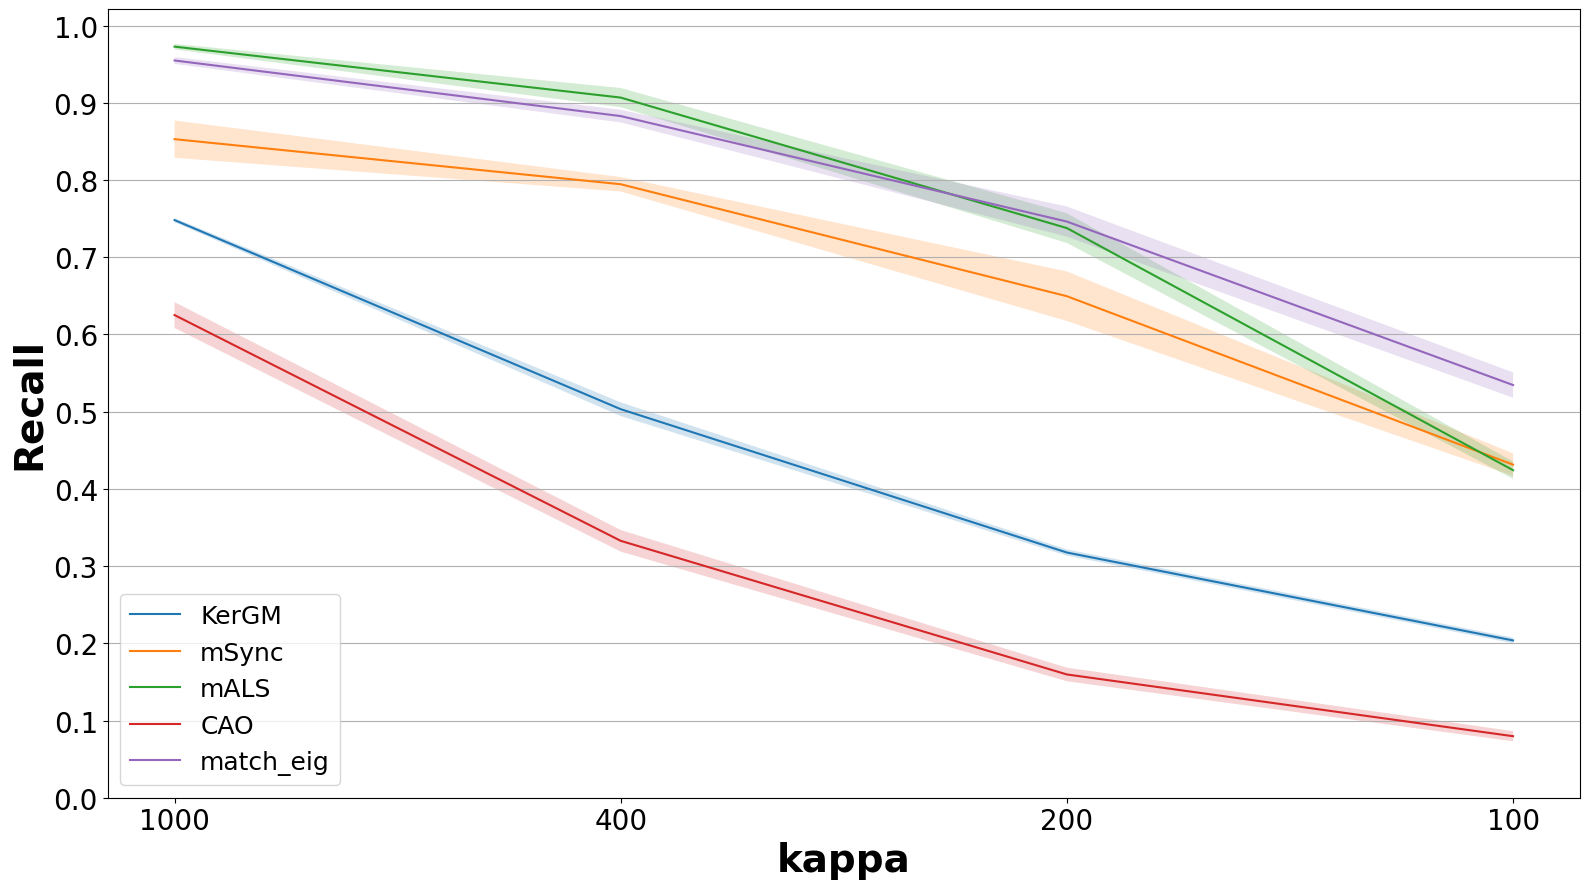

In [94]:
strkergm = [str(k) for k in list(kergm_scores.keys())]

fig = plt.figure(figsize=(16, 9))

# plt.plot(list(k_70.keys()), k_70_rec ,label = 'kmeans k = 70')
# plt.fill_between(list(k_70.keys()), k_70_rec - k_70_rec_std, k_70_rec + k_70_rec_std, alpha=0.2)

# plt.plot(list(k_90.keys()), k_90_rec ,label = 'kmeans k = 90')
# plt.fill_between(list(k_90.keys()), k_90_rec - k_90_rec_std, k_90_rec + k_90_rec_std, alpha=0.2)

# plt.plot(list(k_110.keys()), k_110_rec ,label = 'kmeans k = 110')
# plt.fill_between(list(k_110.keys()), k_110_rec - k_110_rec_std, k_110_rec + k_110_rec_std, alpha=0.2)

plt.plot(strkergm, kergm_rec ,label = 'KerGM')
plt.fill_between(strkergm, kergm_rec - kergm_rec_std, kergm_rec + kergm_rec_std, alpha=0.2)

plt.plot(strkergm, msync_rec ,label = 'mSync')
plt.fill_between(strkergm, msync_rec - msync_rec_std, msync_rec + msync_rec_std, alpha=0.2)

plt.plot(strkergm, mALS_rec ,label = 'mALS')
plt.fill_between(strkergm, mALS_rec - mALS_rec_std, mALS_rec + mALS_rec_std, alpha=0.2)

# plt.plot(list(mALS_scores.keys()), msync_kmeans_mean ,label = 'mSync kmeans')
# plt.fill_between(list(m_Sync_scores.keys()), msync_kmeans_mean - msync_kmeans_std, msync_kmeans_mean + msync_kmeans_std, alpha=0.2)

plt.plot(strkergm, CAO_rec ,label = 'CAO')
plt.fill_between(strkergm, CAO_rec - CAO_rec_std, CAO_rec + CAO_rec_std, alpha=0.2)

plt.plot(strkergm, Match_eig_rec ,label = 'match_eig')
plt.fill_between(strkergm, Match_eig_rec - Match_eig_rec_std, Match_eig_rec + Match_eig_rec_std, alpha=0.2)

plt.xlabel('kappa',fontweight="bold",fontsize=28)
plt.ylabel('Recall',fontweight="bold",fontsize=28)
plt.legend(loc = 'lower left')
#plt.title('F1 Score curve',fontweight="bold",fontsize=24)
plt.gca().yaxis.grid(True)
plt.gca().invert_xaxis()
plt.legend(loc=3, prop={'size': 18})

ytck = list(np.arange(0,1.1,0.1))

plt.xticks(fontsize=20)
plt.yticks(ytck,fontsize=20)

plt.show()
fig.savefig('NEW SIMU Scores_rec match_eig.png')